In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
edge_info = pd.read_pickle('../data/preprocessed/edge_info.pkl')
node_info = pd.read_pickle('../data/preprocessed/node_info.pkl')

In [3]:
len(node_info), len(edge_info)

(124733, 2620473)

In [4]:
node_info[node_info['super_class'] == 'central']

,root_id,name,group,nt_type,nt_type_score,da_avg,ser_avg,gaba_avg,glut_avg,ach_avg,...,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve,length_nm,area_nm,size_nm
46,720575940602090976,SIP_R.FLA_L.1,SIP_R.FLA_L,ACH,0.92,0.04,0.00,0.01,0.03,0.92,...,NaN,NaN,NaN,NaN,DL1_ventral,right,NaN,1388704,3682184832,216011714560
47,720575940602120928,AVLP_R.AVLP_R.1,AVLP_R.AVLP_R,ACH,0.77,0.10,0.03,0.01,0.08,0.77,...,NaN,NaN,NaN,NaN,VLPa1_medial,right,NaN,1816877,4096610176,218489722880
51,720575940602313952,GNG.GNG.1,GNG.GNG,GLUT,0.58,0.01,0.01,0.28,0.58,0.11,...,NaN,NaN,NaN,NaN,LB3,left,NaN,318535,958501760,53967298560
54,720575940602380768,AVLP_R.AMMC_R.1,AVLP_R.AMMC_R,GABA,0.65,0.04,0.03,0.65,0.18,0.10,...,NaN,NaN,NaN,NaN,WEDa1,right,NaN,1144114,4442342016,309903452160
58,720575940602415584,WED_L.WED_L.1,WED_L.WED_L,GABA,0.72,0.02,0.00,0.72,0.05,0.21,...,NaN,NaN,NaN,WED032,WEDa2,left,NaN,721657,1678626176,115126466560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124571,720575940660313729,GNG.SLP_R.28,GNG.SLP_R,ACH,0.95,0.03,0.00,0.01,0.01,0.95,...,NaN,NaN,NaN,NaN,ALl1_ventral,right,NaN,1755438,5538599936,364797030400
124572,720575940660314241,WED_R.AMMC_R.11,WED_R.AMMC_R,GABA,0.64,0.05,0.02,0.64,0.18,0.10,...,NaN,NaN,NaN,NaN,WEDa1,right,NaN,1338423,5134454784,353499811840
124671,720575940660634497,EB.EB.351,EB.EB,GABA,0.96,0.01,0.00,0.96,0.01,0.02,...,CX,ring neuron,NaN,ER4m,EBa1,left,NaN,1247887,7817908480,789220085760
124691,720575940660742785,SPS_L.SAD.13,SPS_L.SAD,ACH,0.85,0.07,0.00,0.02,0.04,0.85,...,NaN,NaN,NaN,NaN,NaN,left,NaN,2800876,12862283648,1499490017280


In [5]:
node_info.sample(10)

,root_id,name,group,nt_type,nt_type_score,da_avg,ser_avg,gaba_avg,glut_avg,ach_avg,...,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve,length_nm,area_nm,size_nm
6062,720575940608799096,SIP_R.SIP_R.4,SIP_R.SIP_R,GLUT,0.93,0.01,0.00,0.04,0.93,0.02,...,NaN,NaN,NaN,NaN,SLPad1_posterior,right,NaN,669836,1805037824,111456860160
98697,720575940632413265,NO_IN.LA_R.447,NO_IN.LA_R,ACH,0.59,0.03,0.01,0.25,0.10,0.59,...,visual,NaN,R1-6,NaN,NaN,right,NaN,55205,569297792,49927444480
112244,720575940638148442,ME_R.LO_R.7129,ME_R.LO_R,ACH,0.62,0.04,0.00,0.10,0.21,0.62,...,optic_lobes,NaN,NaN,NaN,NaN,right,NaN,353414,988320512,68555192320
65996,720575940625471223,ME_L.ME_L.9949,ME_L.ME_L,GLUT,0.54,0.01,0.00,0.37,0.54,0.07,...,optic_lobes,NaN,NaN,NaN,NaN,left,NaN,200682,997441792,78003200000
84397,720575940629172465,ME_R.ME_R.11518,ME_R.ME_R,ACH,0.58,0.16,0.01,0.03,0.19,0.58,...,optic_lobes,NaN,NaN,NaN,NaN,right,NaN,180025,558438016,39296337920
87101,720575940629811574,SMP_L.SMP_L.719,SMP_L.SMP_L,ACH,0.71,0.09,0.17,0.01,0.01,0.71,...,NaN,NaN,NaN,NaN,VLPd&p1_posterior,left,NaN,696490,1846561408,91644119040
594,720575940604272672,GNG.GNG.15,GNG.GNG,NaN,-1.00,0.16,0.38,0.02,0.10,0.33,...,mechanosensory,eye bristle,BM_InOm,NaN,NaN,right,MxLbN,109417,298177664,13393131520
87598,720575940629921654,MB_CA_L.MB_PED_L.180,MB_CA_L.MB_PED_L,ACH,1.00,0.00,0.00,0.00,0.00,1.00,...,Kenyon_Cell,NaN,NaN,KCg-m,MBp4,left,NaN,475353,1552910592,111557386240
7633,720575940609892818,ME_R.ME_R.1038,ME_R.ME_R,GLUT,0.65,0.00,0.00,0.25,0.65,0.07,...,optic_lobes,NaN,NaN,NaN,NaN,right,NaN,162740,608951168,43346247680
46854,720575940621533481,SMP_R.SMP_R.341,SMP_R.SMP_R,GLUT,0.86,0.01,0.00,0.09,0.86,0.04,...,NaN,NaN,NaN,NaN,CLp2,right,NaN,1066691,2644045312,160892672000


In [6]:
from collections import Counter

hl_counter = Counter(node_info['hemilineage'][~node_info['hemilineage'].isna()])
hl_sorted = sorted(hl_counter, key=lambda x: x[1], reverse=True)

In [7]:
hl_counter[hl_sorted[100]]

210

In [8]:
list(hl_sorted)

['MX7',
 'MX12',
 'MX3',
 'MX0',
 'MX7__prim',
 'MX12__prim',
 'PSp2',
 'PSp3',
 'PSa1',
 'PSp1',
 'CREa2_ventral',
 'TRdl_a',
 'TRdl_b',
 'TRdm',
 'CREa1_ventral',
 'CREa2_medial',
 'CREa1_dorsal',
 'CREl1',
 'VPNp&v1_posterior',
 'VPNp1_lateral',
 'VPNp1_medial',
 'VPNd1',
 'VPNl&d1_dorsal',
 'VPNl&d1_lateral',
 'VPNp&v1_ventral',
 'AOTUv4_dorsal',
 'AOTUv3_ventral',
 'AOTUv4_ventral',
 'AOTUv1_ventral',
 'AOTUv3_dorsal',
 'AOTUv2',
 'AOTUv1_medial',
 'DM4_ventral',
 'DM2_central',
 'DM2_CX_p',
 'DM4_CX_v',
 'DM3_CX_v',
 'DM4_CX_d2',
 'DM3_CX_p',
 'DM3_CX_d2',
 'SMPpm1',
 'DM1_CX_p',
 'DM1_antero_ventral',
 'SMPad2',
 'DM2_CX_v',
 'DM4_dorsal',
 'DM6_dorso_medial',
 'DM6_dorso_lateral',
 'DM6_central1',
 'DM4_CX_p',
 'DM5_ventral',
 'DM6_ventral',
 'SMPpv1',
 'DM3_dorso_lateral',
 'DM2_CX_d2',
 'DM3_posterior',
 'DM4_CX_d1',
 'DM3_CX_d1',
 'DM2_CX_d1',
 'SMPp&v1_posterior',
 'SMPp&v1_ventral',
 'DM1_CX_d2',
 'SMPad3',
 'SMPad1',
 'DM1_dorsal',
 'DM1_CX_v',
 'DM6_posterior',
 'SMPpd1'

Exclude optic neurons


In [9]:
node_info = node_info[node_info["super_class"] != "optic"]
edge_info = edge_info[
    edge_info["pre_root_id"].isin(node_info["root_id"])
    & edge_info["post_root_id"].isin(node_info["root_id"])
]

In [10]:
print(f"|V|={len(node_info)}, |E|={len(edge_info)}")

|V|=51405, |E|=1301936


## EXPLORATION  

A. Node and Edge Statistics (see exploitation.ipynb)

B. Degree Distribution

C. Other Properties of the Graph

D. Node Clustering

##### B. Degree Distribution

In [43]:
# build the adjacency matrix

import numpy as np

# Create a list of unique node IDs
node_ids = np.unique(np.concatenate([edge_info['pre_root_id'], edge_info['post_root_id']]))

# Create an empty adjacency matrix filled with zeros
adjacency_matrix = np.zeros((len(node_ids), len(node_ids)))

# Map node IDs to indices
node_indices = {node_id: index for index, node_id in enumerate(node_ids)}

# Iterate over the rows in the table and update the adjacency matrix
for _, row in edge_info.iterrows():
    pre_root_id = row['pre_root_id']
    post_root_id = row['post_root_id']
    pre_root_index = node_indices[pre_root_id]
    post_root_index = node_indices[post_root_id]
    adjacency_matrix[pre_root_index][post_root_index] = 1

print(adjacency_matrix)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [24]:
# check if the adjacency matrix is symmetric
def is_symmetric(matrix):
    return np.allclose(matrix, matrix.T)

is_symmetric(adjacency_matrix)

False

In [59]:
# construct a graph G from the directed adjacency matrix 
G = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

# create an undirected version of the graph
G_undirected = nx.to_undirected(G)


# check some properties of the graph
print(f'Is G directed? {nx.is_directed(G)}')
print(f'Is G connected? {nx.is_connected(G_undirected)}')
print('Number of nodes: {}, Number of edges: {}'. format(G.number_of_nodes(), G.number_of_edges()))
print('Number of weakly connected components: {}'. format(nx.number_weakly_connected_components(G)))
print('Number of strongly connected components: {}'. format(nx.number_strongly_connected_components(G)))
print('Density: {}'. format(nx.density(G)))


Is G directed? True
Is G connected? False
Number of nodes: 49339, Number of edges: 1090673
Number of weakly connected components: 72
Number of strongly connected components: 5194
Density: 0.00044804607642286366


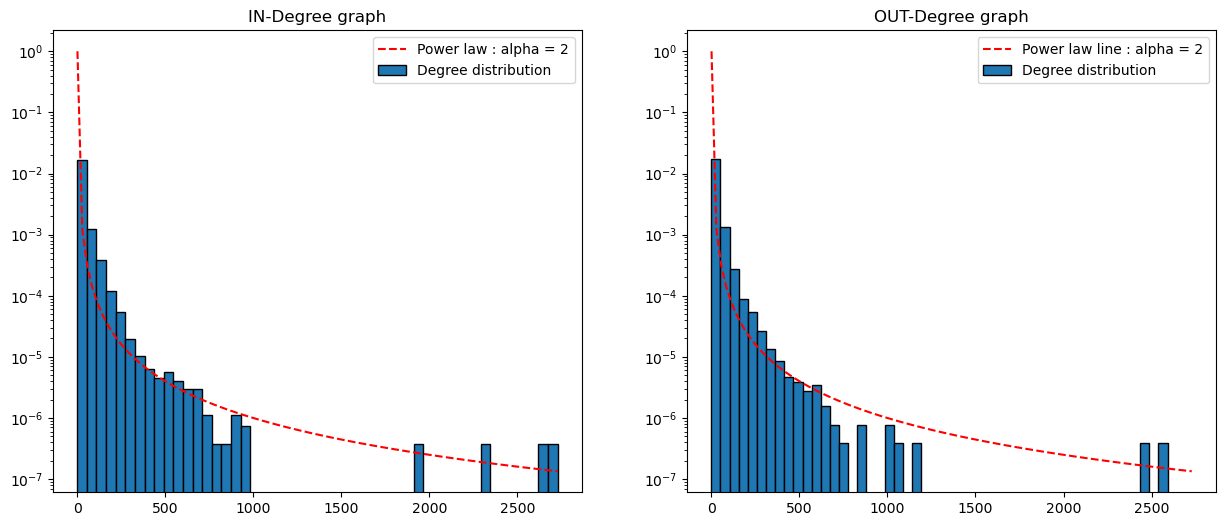

In [126]:
import numpy as np
import matplotlib.pyplot as plt

in_degree = [degree for node, degree in G.in_degree()]
out_degree = [degree for node, degree in G.out_degree()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.set_title('IN-Degree graph')
hist1, bins1, _ = ax1.hist(in_degree, edgecolor='black', bins=50, density=True)
ax1.set_yscale('log')

ax2.set_title('OUT-Degree graph')
hist2, bins2, _ = ax2.hist(out_degree, edgecolor='black', bins=50, density=True)
ax2.set_yscale('log')

# Generate power law line data
max_value = max(max(in_degree), max(out_degree))
x = np.linspace(1, max_value, num=100)
y = x ** (-2)  # Power law distribution with alpha=2

# Plot power law line
ax1.plot(x, y, color='red', linestyle='--')
ax2.plot(x, y, color='red', linestyle='--')

# show legend
ax1.legend(['Power law : alpha = 2', 'Degree distribution'])
ax2.legend(['Power law line : alpha = 2', 'Degree distribution'])



plt.show()


In [127]:
# first and second moments of the degree distribution
moment_1 = np.mean(in_degree)
moment_2 = np.mean(in_degree**2)
print(f"First moment: {moment_1}")
print(f"Second moment: {moment_2}")

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

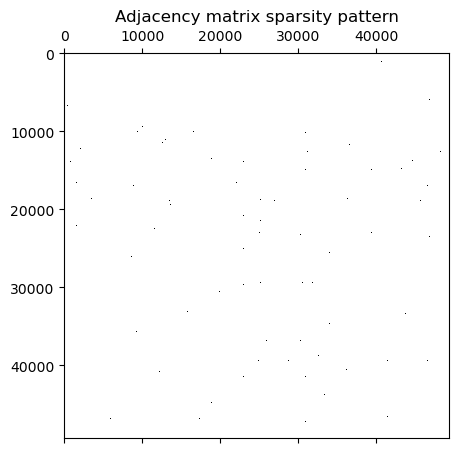

##### C. Other Properties of the Graph

In [31]:
# sparsity of the graph
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title('Adjacency matrix sparsity pattern')
# use spy to visualize the sparsity pattern of the adjacency
ax.spy(adjacency_matrix);

##### D. Node Clustering